In [1]:
import pandas as pd
import numpy as np
import os

# Configuration 
# Input file path for non-adjusted stock price history
input_file_path = 'company_data/C38U.SI_stock_price_history_non_adj.csv'

# 1. Load the Data from your CSV file
print(f"Attempting to load data from: {input_file_path}")
try:
    df = pd.read_csv(input_file_path)
    print("Successfully loaded data.")
except FileNotFoundError:
    print(f"Error: The file at {input_file_path} was not found. Please check the path and filename.")
    exit() # Exit the script if the file isn't found
except Exception as e:
    print(f"An unexpected error occurred during file loading: {e}")
    exit()

# --- 2. Initial Data Preparation ---
print("\nPerforming initial data preparation")
# df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True) 
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True).dt.date

# Set 'Date' as the index and sort it, which is crucial for time-series operations
df = df.set_index('Date').sort_index()

# Ensure Open, High, Low, Close, and Volume columns are numeric.
# Using errors='coerce' will turn any non-convertible values into NaN (Not a Number).
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Remove commas from the 'Volume' column first, then convert to numeric
df['Volume'] = df['Volume'].astype(str).str.replace(',', '', regex=False)
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

print("\n--- Initial Data Snapshot ---")
print(df.head())
print("\n--- Initial Data Info ---")
print(df.info())
print(f"Total rows loaded: {len(df)}")

# 3. Data Cleaning: Remove Non-Trading (e.g., Dividend/Split) Rows and Handle Duplicates 

print("\n--- Starting Data Cleaning Process ---")
initial_row_count = len(df)

# Step 3.1: Identify and Remove Rows Likely Representing Non-Trading Events
# Common indicators for non-trading/dividend rows: Volume is 0 or NaN, or Close price is NaN.
print(f"\nChecking for non-trading rows (Volume 0/NaN or Close NaN)...")
non_trading_rows_mask = (df['Volume'] == 0) | (df['Volume'].isna()) | (df['Close'].isna())

num_non_trading_rows = non_trading_rows_mask.sum()
print(f"Found {num_non_trading_rows} rows likely representing non-trading events.")

# Keep only the rows that are NOT identified as non-trading events.
df = df[~non_trading_rows_mask].copy()

rows_removed_events = initial_row_count - len(df)
if rows_removed_events > 0:
    print(f"Removed {rows_removed_events} non-trading event rows.")
else:
    print("No non-trading event rows found or removed.")

# Step 3.2: Handle Any Remaining Date Duplicates (after removing event rows)
print(f"\nChecking for remaining duplicate dates after non-trading event removal...")
rows_before_duplicate_check = len(df)

# Identify all rows where the index (Date) is duplicated, marking all occurrences.
duplicate_dates_mask = df.index.duplicated(keep=False)
num_duplicate_dates = duplicate_dates_mask.sum()
print(f"Found {num_duplicate_dates} rows with duplicate dates (counting all instances) for removal.")

# Filter the DataFrame to keep only non-duplicate index entries, keeping the first occurrence.
df = df[~df.index.duplicated(keep='first')]

rows_removed_duplicates = rows_before_duplicate_check - len(df)
if rows_removed_duplicates > 0:
    print(f"Removed {rows_removed_duplicates} remaining duplicate date entries.")
else:
    print("No remaining duplicate dates found or removed.")

# Final check for any critical NaNs that might have been missed or introduced.
# This ensures that essential columns for calculations are clean.
df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
print(f"\nTotal rows after all initial cleaning steps: {len(df)}")

print("\n--- Data after Cleaning Snapshot ---")
print(df.head())
print("\n--- Data Info after Cleaning ---")
print(df.info())


Attempting to load data from: company_data/C38U.SI_stock_price_history_non_adj.csv
Successfully loaded data.

Performing initial data preparation

--- Initial Data Snapshot ---
            Open  High   Low  Close     Adj      Volume
Date                                                   
2019-12-31  2.43  2.47  2.43   2.46  1.8324   4710400.0
2020-01-02  2.44  2.47  2.43   2.46  1.8324   8248900.0
2020-01-03  2.46  2.47  2.43   2.45  1.8249   5668600.0
2020-01-06  2.44  2.45  2.42   2.43  1.8100  10843500.0
2020-01-07  2.44  2.47  2.43   2.46  1.8324  12045600.0

--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1271 entries, 2019-12-31 to 2024-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1257 non-null   float64
 1   High    1257 non-null   float64
 2   Low     1257 non-null   float64
 3   Close   1257 non-null   float64
 4   Adj     1257 non-null   float64
 5   Volume  1251 non

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 180, 32)             │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 180, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,241 (118.13 KB)

 Trainable params: 30,241 (118.13 KB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.0678 - val_loss: 0.0067
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0074 - val_loss: 0.0088
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 12/100
24/24

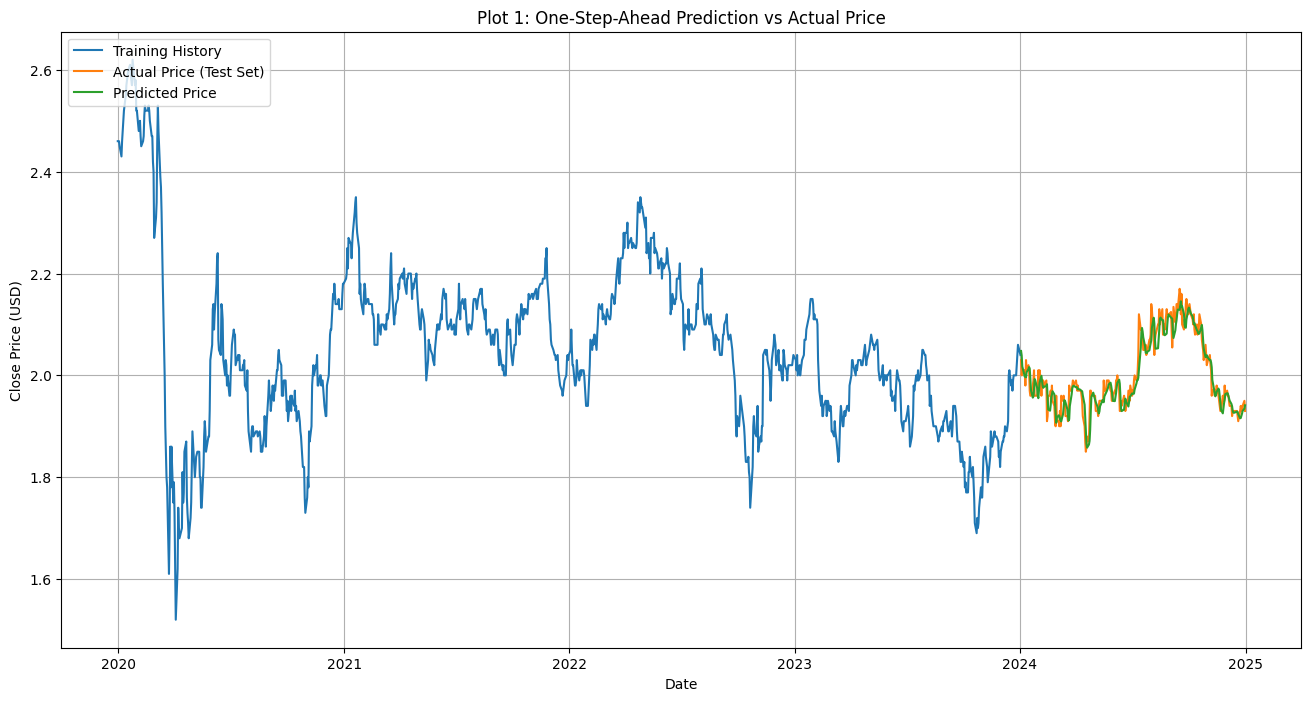


--- Starting Iterative Trend Forecasting for 90 days ---


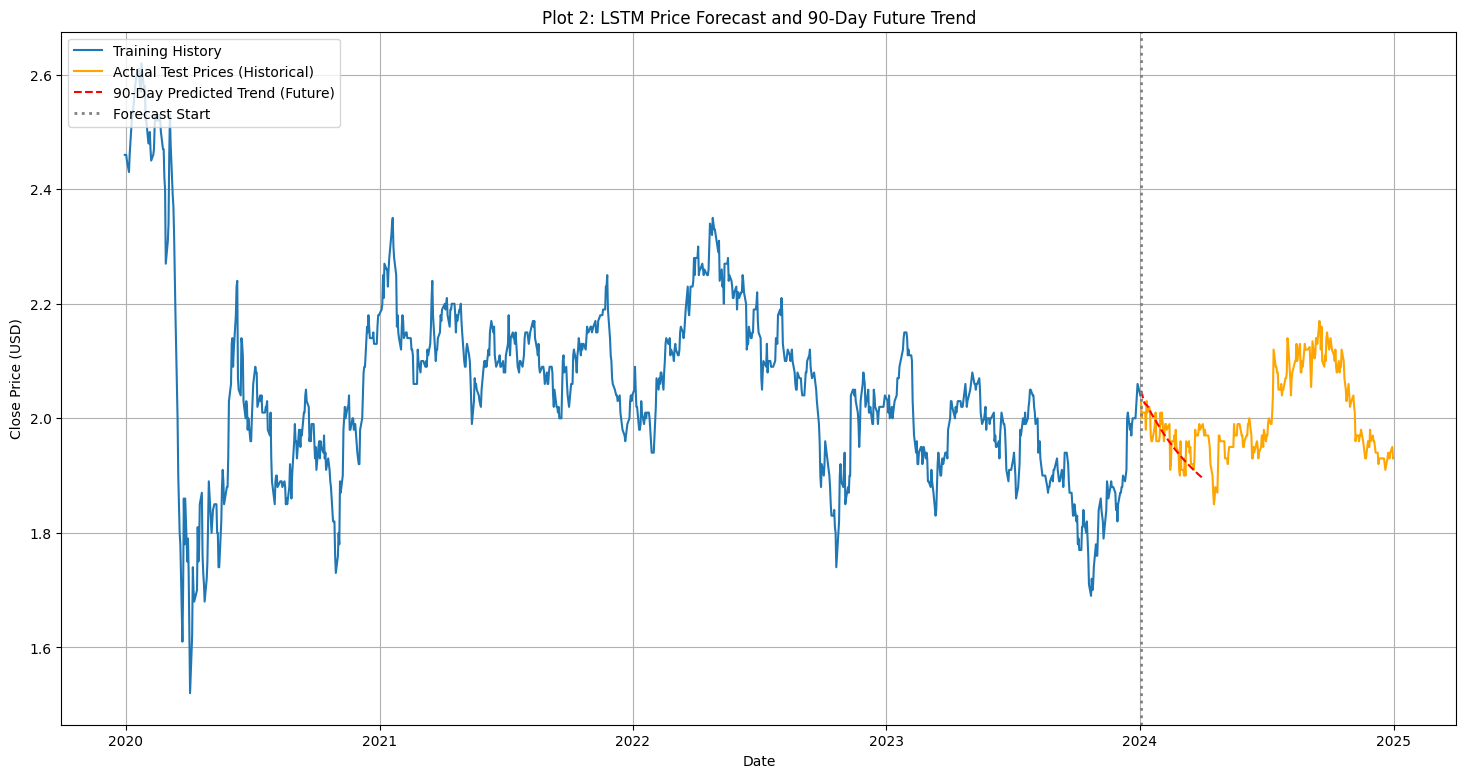


--- 90-Day Trend Analysis ---
Forecast Start Price: 2.0479
Forecast End Price: 1.8954
Overall Predicted Change: -7.45%
Conclusion: Predicted long-term trend is DOWN (Bearish).


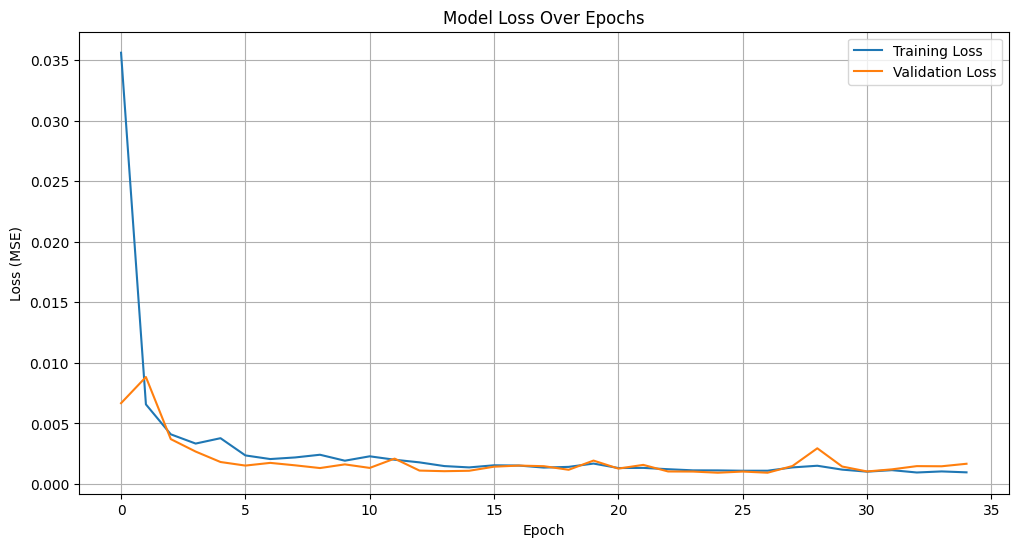

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# --- 1. Load and Prepare Data ---
# try:
#     df = pd.read_csv('calculated_averages/C38U.SI_stock_price_history_with_indicators.csv', parse_dates=['Date'], index_col='Date')
# except FileNotFoundError:
#     print("Error: CSV file not found. Please check that the file path is correct.")
#     exit()

# We only need the 'Close' price for this example
data = df.filter(['Close'])
dataset = data.values # Convert to numpy array

# MinMaxScaler Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# 2. Create Sequences 
SEQ_LEN = 180 # Look-back window

# Split data into training and testing sets (80% train, 20% test)
train_data_len = int(np.ceil(len(dataset) * .8))
train_data = scaled_data[0:int(train_data_len), :]

# Create the training data set
x_train = []
y_train = []
for i in range(SEQ_LEN, len(train_data)):
    x_train.append(train_data[i-SEQ_LEN:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# --- 3. Build the LSTM Model (Corrected) ---
model = Sequential()
# Add the Input layer first to define the shape, this removes the warning
model.add(Input(shape=(x_train.shape[1], 1)))
# The LSTM layer no longer needs the input_shape argument
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1))

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=custom_optimizer, loss='mean_squared_error')
model.summary()

# --- 4. Train and Save the Model ---
print("\nTraining the model...")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=100,
    callbacks=[early_stop],
    validation_split=0.1
)

# Save the trained model
print("\n--- Saving the trained model to 'univariate_lstm_model.keras' ---")
model.save('univariate_lstm_model.keras')

# PART A: ONE-STEP-AHEAD EVALUATION ON TEST SET

# --- 5. Create the Testing Data Set ---
test_data = scaled_data[train_data_len - SEQ_LEN:, :]
x_test = []
y_test = dataset[train_data_len:, :]

for i in range(SEQ_LEN, len(test_data)):
    x_test.append(test_data[i-SEQ_LEN:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# --- 6. Get the Model's Predicted Price Values ---
print("\nEvaluating the model on the test set...")
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# --- 7. Evaluate Model Performance ---
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# --- 8. Visualize the Test Set Predictions ---
train_plot_data = data[:train_data_len]
valid_plot_data = data[train_data_len:].copy()
valid_plot_data['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Plot 1: One-Step-Ahead Prediction vs Actual Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.plot(train_plot_data['Close'], label='Training History')
plt.plot(valid_plot_data['Close'], label='Actual Price (Test Set)')
plt.plot(valid_plot_data['Predictions'], label='Predicted Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


# PART B: 90-DAY FUTURE FORECAST

# --- 9. Perform Iterative Forecasting for Future Trend ---
N_STEPS = 90
print(f"\n--- Starting Iterative Trend Forecasting for {N_STEPS} days ---")

initial_sequence = scaled_data[train_data_len - SEQ_LEN:train_data_len]
current_input = initial_sequence.reshape(1, SEQ_LEN, 1)
future_predictions_scaled = []

for i in range(N_STEPS):
    next_prediction_scaled = model.predict(current_input, verbose=0)[0, 0]
    future_predictions_scaled.append(next_prediction_scaled)
    
    new_input_list = current_input[0, :, 0].tolist()
    new_input_list.pop(0)
    new_input_list.append(next_prediction_scaled)
    current_input = np.array(new_input_list).reshape(1, SEQ_LEN, 1)

predictions_array = np.array(future_predictions_scaled).reshape(-1, 1)
future_predictions_price = scaler.inverse_transform(predictions_array)

last_train_date = df.index[train_data_len - 1]
future_dates = pd.date_range(start=last_train_date, periods=N_STEPS + 1, inclusive='right')
future_df = pd.DataFrame(
    future_predictions_price,
    index=future_dates,
    columns=['Predicted_Trend_Price']
)

# --- 10. Visualize the Future Forecast Results ---
train = data[:train_data_len]
valid = data[train_data_len:]

plt.figure(figsize=(18, 9))
plt.title(f'Plot 2: LSTM Price Forecast and {N_STEPS}-Day Future Trend')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.plot(train['Close'], label='Training History')
plt.plot(valid['Close'], label='Actual Test Prices (Historical)', color='orange')
plt.plot(future_df['Predicted_Trend_Price'], label=f'{N_STEPS}-Day Predicted Trend (Future)', color='red', linestyle='--')
forecast_start_date = future_df.index[0]
plt.axvline(x=forecast_start_date, color='grey', linestyle=':', linewidth=2, label='Forecast Start')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# --- PART C: MODEL DIAGNOSTICS & ANALYSIS ---

# 11. Trend Analysis and Conclusion
print(f'\n--- {N_STEPS}-Day Trend Analysis ---')
if not future_df.empty:
    start_price = future_df.iloc[0]['Predicted_Trend_Price']
    end_price = future_df.iloc[-1]['Predicted_Trend_Price']
    trend_change = ((end_price - start_price) / start_price) * 100

    print(f'Forecast Start Price: {start_price:.4f}')
    print(f'Forecast End Price: {end_price:.4f}')
    print(f'Overall Predicted Change: {trend_change:.2f}%')
    
    if trend_change > 1.0:
        print('Conclusion: Predicted long-term trend is UP (Bullish).')
    elif trend_change < -1.0:
        print('Conclusion: Predicted long-term trend is DOWN (Bearish).')
    else:
        print('Conclusion: Predicted long-term trend is relatively FLAT (Sideways).')
else:
    print('Forecasting failed or resulted in an empty trend DataFrame.')

# --- 12. Visualize Training Loss ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()